In [1]:
from dataset import Digits_Dataset, DataLoader
from models.dann import FeatureExtractor, LabelPredictor

import torch
from torchvision import transforms
import numpy as np
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline



In [2]:
# load model
def load_feature_extractor(source, target):
    global device
    load = torch.load(f'./result/3_2/{source}2{target}/best_model.pth')
    feature_extractor = FeatureExtractor()
    feature_extractor.load_state_dict(load['F'])
    feature_extractor.eval()
    feature_extractor.to(device)
    return feature_extractor

# get latent vectors
@torch.no_grad()
def get_latents(feature_extractor, dataloader):
    latents = []
    labels = []
    for i, (imgs, lbls) in enumerate(dataloader):
        features = feature_extractor(imgs.to(device))
        latents.append(features.cpu())
        labels.append(lbls)
        print(f' [{i+1}/{len(dataloader)}]', end='   \r')
        
    return torch.cat(latents, dim=0), torch.cat(labels, dim=0)

# Plot
def plot(feature_extractor, source_dataloader, target_dataloader, source, target):
    # get latents & labels
    source_latents, source_labels = get_latents(feature_extractor, source_dataloader)
    target_latents, target_labels = get_latents(feature_extractor, target_dataloader)
    
    len_ = min(source_latents.shape[0], target_latents.shape[0])
    
    all_latents = torch.cat([source_latents[:len_], target_latents[:len_]], dim=0)
    all_labels = torch.cat([source_labels[:len_], target_labels[:len_]], dim=0)

    # dimension reduction
    X_tsne = TSNE(n_components=2, random_state=87).fit_transform(all_latents)
    y = all_labels.numpy().astype(np.int)

    # x normalization
    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne - x_min) / (x_max - x_min)  #Normalize
    #X_norm = X_tsne
    
    ####################################################
    ################## plot class 0~9 ##################
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title(f't-SNE of DANN [{source}→{target}], 0~9')
    p_s = []
    for j in range(10):
        idxs = (all_labels==j)
        plt.scatter(X_norm[idxs, 0], X_norm[idxs, 1], label=f'{j}')
    plt.legend(loc='best')
    #plt.show()

    #################################################
    ################## plot domain ##################
    #plt.figure(figsize=(15,7))
    plt.subplot(1,2,2)
    plt.title(f't-SNE of DANN [{source}→{target}], domain')
    split = len_
    # plot source domain
    plt.scatter(X_norm[:split, 0], X_norm[:split, 1], c=['#1f77b4']*split, alpha=0.2, label=f'source:{source}')
    # plot target domain
    plt.scatter(X_norm[split:, 0], X_norm[split:, 1], c=['#2ca02c']*split, alpha=0.2, label=f'target:{target}')
    plt.legend(loc='best')
    plt.show()
    

In [3]:
size = 64
trans = transforms.Compose([
        transforms.Resize(size),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

device = 'cuda:0'
root = '../hw3_data/digits/'

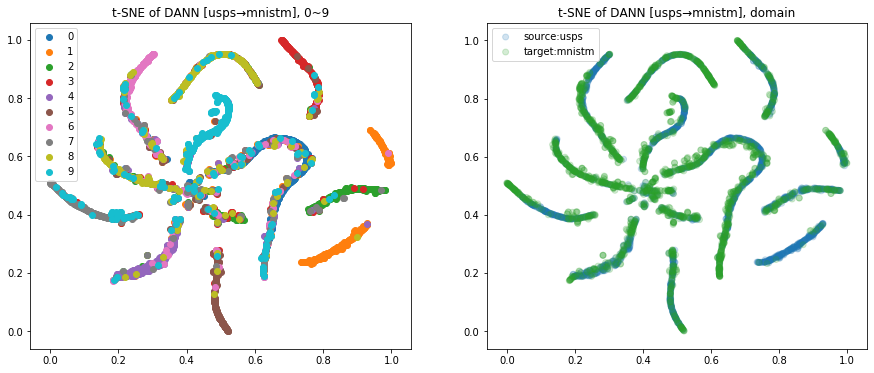

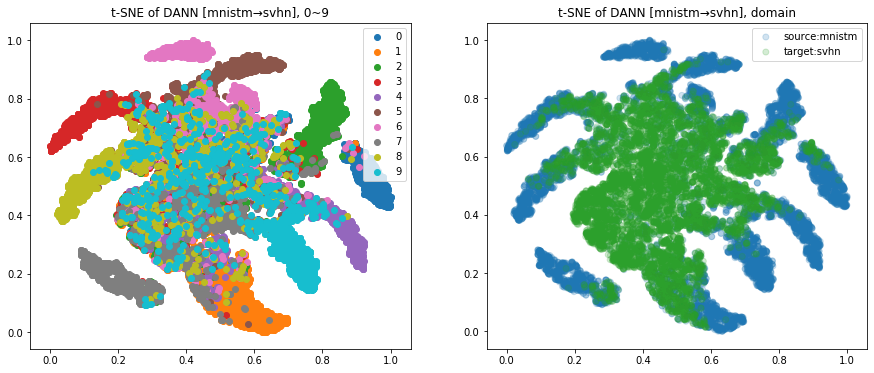

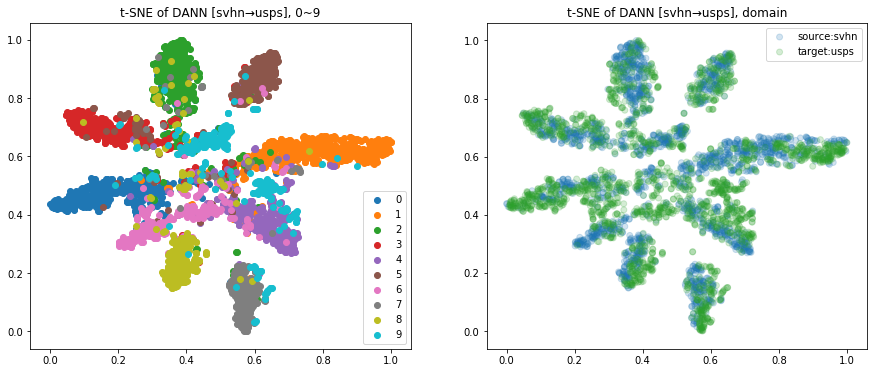

In [4]:
%matplotlib inline

transfers = [('usps','mnistm'), ('mnistm','svhn'), ('svhn','usps')]

for source, target in transfers:
        
    # load dataset & dataloader
    source_dataset = Digits_Dataset(root+f'/{source}/test/', source, trans)
    target_dataset = Digits_Dataset(root+f'/{target}/test/', target, trans)
    source_dataloader = DataLoader(source_dataset,
                                  batch_size=256,
                                  num_workers=6,
                                  collate_fn=source_dataset.collate_fn)
    target_dataloader = DataLoader(target_dataset,
                                  batch_size=256,
                                  num_workers=6,
                                  collate_fn=target_dataset.collate_fn)
        
    # load model
    feature_extractor = load_feature_extractor(source, target)
        
    # plot
    plot(feature_extractor, source_dataloader, target_dataloader, source, target)
        
    del feature_extractor
    